In [1]:
#%mkdir ComputerVision
%cd ComputerVision

/home/cvmlserver3/jihee/ComputerVision


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import time
from tqdm import tqdm
from pytorch_pretrained_vit import ViT
import matplotlib.pyplot as plt

In [3]:
# 데이터 증강 및 정규화 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT는 224x224 입력을 기대
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 정규화 범위 수정
])

# CIFAR-10 데이터셋 다운로드 및 로더 설정
full_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 전체 데이터를 학습, 검증, 테스트 데이터로 분할
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
train_dataset, val_dataset, _ = random_split(full_dataset, [train_size, val_size, len(full_dataset) - train_size - val_size])

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# 사전 학습된 ViT 모델 불러오기
model = ViT('B_16', pretrained=True, image_size=224, patches=4)

# CIFAR-10은 10개의 클래스를 가지므로, 마지막 레이어를 수정
model.fc = nn.Linear(model.fc.in_features, 10)

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Multi-GPU 지원을 위해 DataParallel 사용
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# 모델을 GPU로 이동
device = torch.device("cuda")
model.to(device)

Resized positional embeddings from torch.Size([1, 197, 768]) to torch.Size([1, 197, 768])
Loaded pretrained weights.


DataParallel(
  (module): ViT(
    (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (positional_embedding): PositionalEmbedding1D()
    (transformer): Transformer(
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (attn): MultiHeadedSelfAttention(
            (proj_q): Linear(in_features=768, out_features=768, bias=True)
            (proj_k): Linear(in_features=768, out_features=768, bias=True)
            (proj_v): Linear(in_features=768, out_features=768, bias=True)
            (drop): Dropout(p=0.1, inplace=False)
          )
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (pwff): PositionWiseFeedForward(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
   

In [5]:
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    model.train()
    trainloader_tqdm = tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    for data in trainloader_tqdm:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update tqdm description
        trainloader_tqdm.set_postfix(loss=running_loss / (total / labels.size(0)), accuracy=100 * correct / total)

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(valloader, desc='Validation', unit='batch'):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(valloader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    epoch_time = end_time - start_time
    remaining_time = epoch_time * (num_epochs - epoch - 1)
    eta = time.strftime("%H:%M:%S", time.gmtime(remaining_time))

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, '
          f'ETA: {eta}')
    if epoch % 10 == 0:
        # 모델 저장
        torch.save(model.state_dict(), f'vit_cifar10_{epoch}.pth')
        print(f'saved model at epoch {epoch}')

print('Finished Training')

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.78batch/s]


Epoch [1/100], Train Loss: 1.7190, Train Accuracy: 35.34%, Val Loss: 1.4357, Val Accuracy: 46.06%, ETA: 06:22:52
saved model at epoch 0


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.80batch/s]


Epoch [2/100], Train Loss: 1.2295, Train Accuracy: 55.42%, Val Loss: 1.0972, Val Accuracy: 60.88%, ETA: 06:18:26


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.82batch/s]


Epoch [3/100], Train Loss: 0.9841, Train Accuracy: 64.91%, Val Loss: 0.9622, Val Accuracy: 66.28%, ETA: 06:16:24


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.73batch/s]


Epoch [4/100], Train Loss: 0.8383, Train Accuracy: 70.06%, Val Loss: 0.8511, Val Accuracy: 70.42%, ETA: 06:14:04


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.75batch/s]


Epoch [5/100], Train Loss: 0.7337, Train Accuracy: 74.09%, Val Loss: 0.7689, Val Accuracy: 73.34%, ETA: 06:08:28


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.82batch/s]


Epoch [6/100], Train Loss: 0.6612, Train Accuracy: 76.51%, Val Loss: 0.7941, Val Accuracy: 73.06%, ETA: 06:05:58


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.74batch/s]


Epoch [7/100], Train Loss: 0.5910, Train Accuracy: 79.17%, Val Loss: 0.7531, Val Accuracy: 74.66%, ETA: 06:01:17


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.78batch/s]


Epoch [8/100], Train Loss: 0.5281, Train Accuracy: 81.28%, Val Loss: 0.6880, Val Accuracy: 76.18%, ETA: 05:56:55


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.81batch/s]


Epoch [9/100], Train Loss: 0.4777, Train Accuracy: 83.35%, Val Loss: 0.6625, Val Accuracy: 78.28%, ETA: 05:53:19


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.70batch/s]


Epoch [10/100], Train Loss: 0.4413, Train Accuracy: 84.46%, Val Loss: 0.6394, Val Accuracy: 78.96%, ETA: 05:48:55


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.77batch/s]


Epoch [11/100], Train Loss: 0.4009, Train Accuracy: 85.83%, Val Loss: 0.6228, Val Accuracy: 79.54%, ETA: 05:45:01
saved model at epoch 10


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.77batch/s]


Epoch [12/100], Train Loss: 0.3587, Train Accuracy: 87.25%, Val Loss: 0.6252, Val Accuracy: 79.64%, ETA: 05:41:20


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.77batch/s]


Epoch [13/100], Train Loss: 0.3283, Train Accuracy: 88.47%, Val Loss: 0.6187, Val Accuracy: 80.24%, ETA: 05:36:55


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.76batch/s]


Epoch [14/100], Train Loss: 0.2942, Train Accuracy: 89.48%, Val Loss: 0.6257, Val Accuracy: 80.76%, ETA: 05:32:50


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.75batch/s]


Epoch [15/100], Train Loss: 0.2737, Train Accuracy: 90.28%, Val Loss: 0.6403, Val Accuracy: 80.76%, ETA: 05:28:38


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.74batch/s]


Epoch [16/100], Train Loss: 0.2468, Train Accuracy: 91.25%, Val Loss: 0.6340, Val Accuracy: 80.66%, ETA: 05:25:36


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.76batch/s]


Epoch [17/100], Train Loss: 0.2249, Train Accuracy: 92.05%, Val Loss: 0.6467, Val Accuracy: 80.90%, ETA: 05:21:32


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.73batch/s]


Epoch [18/100], Train Loss: 0.2030, Train Accuracy: 92.80%, Val Loss: 0.6521, Val Accuracy: 81.52%, ETA: 05:17:25


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.78batch/s]


Epoch [19/100], Train Loss: 0.1903, Train Accuracy: 93.26%, Val Loss: 0.6898, Val Accuracy: 81.26%, ETA: 05:13:08


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.75batch/s]


Epoch [20/100], Train Loss: 0.1833, Train Accuracy: 93.53%, Val Loss: 0.7064, Val Accuracy: 81.98%, ETA: 05:09:32


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.81batch/s]


Epoch [21/100], Train Loss: 0.1667, Train Accuracy: 94.03%, Val Loss: 0.6919, Val Accuracy: 81.22%, ETA: 05:05:07
saved model at epoch 20


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.80batch/s]


Epoch [22/100], Train Loss: 0.1584, Train Accuracy: 94.28%, Val Loss: 0.7647, Val Accuracy: 80.40%, ETA: 05:01:20


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.79batch/s]


Epoch [23/100], Train Loss: 0.1408, Train Accuracy: 95.05%, Val Loss: 0.7821, Val Accuracy: 80.38%, ETA: 04:57:35


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.74batch/s]


Epoch [24/100], Train Loss: 0.1449, Train Accuracy: 94.75%, Val Loss: 0.7068, Val Accuracy: 81.30%, ETA: 04:53:56


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.84batch/s]


Epoch [25/100], Train Loss: 0.1279, Train Accuracy: 95.38%, Val Loss: 0.8216, Val Accuracy: 79.54%, ETA: 04:49:05


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.80batch/s]


Epoch [26/100], Train Loss: 0.1278, Train Accuracy: 95.55%, Val Loss: 0.8111, Val Accuracy: 81.32%, ETA: 04:45:02


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.79batch/s]


Epoch [27/100], Train Loss: 0.1218, Train Accuracy: 95.65%, Val Loss: 0.7733, Val Accuracy: 82.22%, ETA: 04:41:46


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.79batch/s]


Epoch [28/100], Train Loss: 0.1110, Train Accuracy: 96.06%, Val Loss: 0.8490, Val Accuracy: 80.52%, ETA: 04:37:47


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.75batch/s]


Epoch [29/100], Train Loss: 0.1116, Train Accuracy: 95.99%, Val Loss: 0.7777, Val Accuracy: 81.32%, ETA: 04:32:41


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.76batch/s]


Epoch [30/100], Train Loss: 0.1061, Train Accuracy: 96.25%, Val Loss: 0.8619, Val Accuracy: 79.66%, ETA: 04:30:11


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.79batch/s]


Epoch [31/100], Train Loss: 0.1007, Train Accuracy: 96.47%, Val Loss: 0.8074, Val Accuracy: 81.34%, ETA: 04:25:33
saved model at epoch 30


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.88batch/s]


Epoch [32/100], Train Loss: 0.0992, Train Accuracy: 96.55%, Val Loss: 0.7975, Val Accuracy: 81.24%, ETA: 04:21:20


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.76batch/s]


Epoch [33/100], Train Loss: 0.0947, Train Accuracy: 96.58%, Val Loss: 0.7841, Val Accuracy: 81.78%, ETA: 04:18:04


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.75batch/s]


Epoch [34/100], Train Loss: 0.0904, Train Accuracy: 96.85%, Val Loss: 0.7861, Val Accuracy: 81.34%, ETA: 04:14:23


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.82batch/s]


Epoch [35/100], Train Loss: 0.0870, Train Accuracy: 96.86%, Val Loss: 0.7774, Val Accuracy: 82.00%, ETA: 04:09:09


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.80batch/s]


Epoch [36/100], Train Loss: 0.0902, Train Accuracy: 96.86%, Val Loss: 0.7285, Val Accuracy: 82.02%, ETA: 04:06:36


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.68batch/s]


Epoch [37/100], Train Loss: 0.0821, Train Accuracy: 97.15%, Val Loss: 0.8075, Val Accuracy: 80.82%, ETA: 04:02:05


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.79batch/s]


Epoch [38/100], Train Loss: 0.0834, Train Accuracy: 97.11%, Val Loss: 0.7998, Val Accuracy: 81.98%, ETA: 03:58:24


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.68batch/s]


Epoch [39/100], Train Loss: 0.0799, Train Accuracy: 97.16%, Val Loss: 0.8048, Val Accuracy: 81.70%, ETA: 03:54:59


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.78batch/s]


Epoch [40/100], Train Loss: 0.0772, Train Accuracy: 97.31%, Val Loss: 0.8157, Val Accuracy: 81.34%, ETA: 03:49:12


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.73batch/s]


Epoch [41/100], Train Loss: 0.0770, Train Accuracy: 97.35%, Val Loss: 0.7705, Val Accuracy: 82.76%, ETA: 03:46:59
saved model at epoch 40


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.83batch/s]


Epoch [42/100], Train Loss: 0.0734, Train Accuracy: 97.32%, Val Loss: 0.8334, Val Accuracy: 81.58%, ETA: 03:42:49


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.76batch/s]


Epoch [43/100], Train Loss: 0.0741, Train Accuracy: 97.43%, Val Loss: 0.8586, Val Accuracy: 81.72%, ETA: 03:39:13


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.85batch/s]


Epoch [44/100], Train Loss: 0.0702, Train Accuracy: 97.47%, Val Loss: 0.7745, Val Accuracy: 82.62%, ETA: 03:34:31


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.77batch/s]


Epoch [45/100], Train Loss: 0.0767, Train Accuracy: 97.34%, Val Loss: 0.8041, Val Accuracy: 82.06%, ETA: 03:30:47


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.87batch/s]


Epoch [46/100], Train Loss: 0.0653, Train Accuracy: 97.69%, Val Loss: 0.8339, Val Accuracy: 82.22%, ETA: 03:27:23


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.80batch/s]


Epoch [47/100], Train Loss: 0.0677, Train Accuracy: 97.72%, Val Loss: 0.8653, Val Accuracy: 81.64%, ETA: 03:23:24


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.81batch/s]


Epoch [48/100], Train Loss: 0.0639, Train Accuracy: 97.83%, Val Loss: 0.7794, Val Accuracy: 82.08%, ETA: 03:20:08


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.76batch/s]


Epoch [49/100], Train Loss: 0.0614, Train Accuracy: 97.80%, Val Loss: 0.8223, Val Accuracy: 82.72%, ETA: 03:15:57


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.82batch/s]


Epoch [50/100], Train Loss: 0.0659, Train Accuracy: 97.75%, Val Loss: 0.7755, Val Accuracy: 82.68%, ETA: 03:12:00


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.74batch/s]


Epoch [51/100], Train Loss: 0.0557, Train Accuracy: 98.09%, Val Loss: 0.9241, Val Accuracy: 81.30%, ETA: 03:08:27
saved model at epoch 50


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.81batch/s]


Epoch [52/100], Train Loss: 0.0658, Train Accuracy: 97.69%, Val Loss: 0.7898, Val Accuracy: 83.00%, ETA: 03:04:11


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.79batch/s]


Epoch [53/100], Train Loss: 0.0602, Train Accuracy: 97.83%, Val Loss: 0.7520, Val Accuracy: 83.12%, ETA: 03:00:29


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.82batch/s]


Epoch [54/100], Train Loss: 0.0541, Train Accuracy: 98.12%, Val Loss: 0.8432, Val Accuracy: 82.60%, ETA: 02:56:21


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.84batch/s]


Epoch [55/100], Train Loss: 0.0627, Train Accuracy: 97.90%, Val Loss: 0.9706, Val Accuracy: 81.58%, ETA: 02:52:33


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.83batch/s]


Epoch [56/100], Train Loss: 0.0619, Train Accuracy: 97.86%, Val Loss: 0.7609, Val Accuracy: 83.54%, ETA: 02:48:55


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.83batch/s]


Epoch [57/100], Train Loss: 0.0543, Train Accuracy: 98.11%, Val Loss: 0.8076, Val Accuracy: 82.88%, ETA: 02:44:55


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.80batch/s]


Epoch [58/100], Train Loss: 0.0507, Train Accuracy: 98.22%, Val Loss: 0.9823, Val Accuracy: 80.88%, ETA: 02:41:22


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.74batch/s]


Epoch [59/100], Train Loss: 0.0569, Train Accuracy: 98.05%, Val Loss: 0.9173, Val Accuracy: 82.74%, ETA: 02:37:33


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.82batch/s]


Epoch [60/100], Train Loss: 0.0551, Train Accuracy: 98.11%, Val Loss: 0.8477, Val Accuracy: 82.36%, ETA: 02:33:30


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.80batch/s]


Epoch [61/100], Train Loss: 0.0550, Train Accuracy: 98.09%, Val Loss: 0.8682, Val Accuracy: 82.20%, ETA: 02:29:47
saved model at epoch 60


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.77batch/s]


Epoch [62/100], Train Loss: 0.0498, Train Accuracy: 98.26%, Val Loss: 0.8539, Val Accuracy: 81.42%, ETA: 02:25:45


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.81batch/s]


Epoch [63/100], Train Loss: 0.0516, Train Accuracy: 98.22%, Val Loss: 0.8367, Val Accuracy: 83.64%, ETA: 02:21:46


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.74batch/s]


Epoch [64/100], Train Loss: 0.0491, Train Accuracy: 98.33%, Val Loss: 0.8474, Val Accuracy: 83.12%, ETA: 02:18:10


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.73batch/s]


Epoch [65/100], Train Loss: 0.0557, Train Accuracy: 98.05%, Val Loss: 0.8805, Val Accuracy: 80.74%, ETA: 02:14:20


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.85batch/s]


Epoch [66/100], Train Loss: 0.0487, Train Accuracy: 98.40%, Val Loss: 0.9994, Val Accuracy: 80.76%, ETA: 02:10:27


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.79batch/s]


Epoch [67/100], Train Loss: 0.0504, Train Accuracy: 98.33%, Val Loss: 0.8216, Val Accuracy: 83.32%, ETA: 02:06:24


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.77batch/s]


Epoch [68/100], Train Loss: 0.0461, Train Accuracy: 98.41%, Val Loss: 0.8014, Val Accuracy: 83.20%, ETA: 02:02:46


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.81batch/s]


Epoch [69/100], Train Loss: 0.0500, Train Accuracy: 98.31%, Val Loss: 0.8407, Val Accuracy: 83.20%, ETA: 01:58:58


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.75batch/s]


Epoch [70/100], Train Loss: 0.0487, Train Accuracy: 98.34%, Val Loss: 0.8769, Val Accuracy: 82.74%, ETA: 01:55:19


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.84batch/s]


Epoch [71/100], Train Loss: 0.0437, Train Accuracy: 98.53%, Val Loss: 0.8389, Val Accuracy: 83.06%, ETA: 01:51:05
saved model at epoch 70


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.78batch/s]


Epoch [72/100], Train Loss: 0.0453, Train Accuracy: 98.37%, Val Loss: 0.8549, Val Accuracy: 82.50%, ETA: 01:47:36


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.80batch/s]


Epoch [73/100], Train Loss: 0.0469, Train Accuracy: 98.34%, Val Loss: 0.8643, Val Accuracy: 82.44%, ETA: 01:43:27


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.91batch/s]


Epoch [74/100], Train Loss: 0.0446, Train Accuracy: 98.47%, Val Loss: 0.8798, Val Accuracy: 81.78%, ETA: 01:39:32


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.72batch/s]


Epoch [75/100], Train Loss: 0.0483, Train Accuracy: 98.33%, Val Loss: 0.9869, Val Accuracy: 81.76%, ETA: 01:36:05


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.81batch/s]


Epoch [76/100], Train Loss: 0.0391, Train Accuracy: 98.69%, Val Loss: 0.9323, Val Accuracy: 82.12%, ETA: 01:32:08


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.81batch/s]


Epoch [77/100], Train Loss: 0.0496, Train Accuracy: 98.28%, Val Loss: 0.7714, Val Accuracy: 83.26%, ETA: 01:28:03


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.79batch/s]


Epoch [78/100], Train Loss: 0.0440, Train Accuracy: 98.53%, Val Loss: 0.8597, Val Accuracy: 82.56%, ETA: 01:24:26


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.88batch/s]


Epoch [79/100], Train Loss: 0.0418, Train Accuracy: 98.56%, Val Loss: 1.0290, Val Accuracy: 82.82%, ETA: 01:20:28


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.89batch/s]


Epoch [80/100], Train Loss: 0.0378, Train Accuracy: 98.73%, Val Loss: 0.9683, Val Accuracy: 82.64%, ETA: 01:16:27


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.74batch/s]


Epoch [81/100], Train Loss: 0.0432, Train Accuracy: 98.53%, Val Loss: 0.8235, Val Accuracy: 82.46%, ETA: 01:12:45
saved model at epoch 80


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.84batch/s]


Epoch [82/100], Train Loss: 0.0460, Train Accuracy: 98.46%, Val Loss: 0.8342, Val Accuracy: 82.70%, ETA: 01:08:59


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.74batch/s]


Epoch [83/100], Train Loss: 0.0367, Train Accuracy: 98.73%, Val Loss: 0.8316, Val Accuracy: 83.46%, ETA: 01:05:05


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.84batch/s]


Epoch [84/100], Train Loss: 0.0439, Train Accuracy: 98.55%, Val Loss: 0.8623, Val Accuracy: 82.86%, ETA: 01:01:10


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.81batch/s]


Epoch [85/100], Train Loss: 0.0406, Train Accuracy: 98.61%, Val Loss: 0.9514, Val Accuracy: 81.06%, ETA: 00:57:33


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.78batch/s]


Epoch [86/100], Train Loss: 0.0448, Train Accuracy: 98.47%, Val Loss: 0.8486, Val Accuracy: 82.76%, ETA: 00:53:43


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.80batch/s]


Epoch [87/100], Train Loss: 0.0347, Train Accuracy: 98.78%, Val Loss: 0.8949, Val Accuracy: 82.44%, ETA: 00:49:37


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.81batch/s]


Epoch [88/100], Train Loss: 0.0376, Train Accuracy: 98.72%, Val Loss: 0.8816, Val Accuracy: 83.42%, ETA: 00:46:01


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.78batch/s]


Epoch [89/100], Train Loss: 0.0392, Train Accuracy: 98.67%, Val Loss: 0.8539, Val Accuracy: 83.54%, ETA: 00:42:06


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.81batch/s]


Epoch [90/100], Train Loss: 0.0394, Train Accuracy: 98.68%, Val Loss: 0.9472, Val Accuracy: 82.48%, ETA: 00:38:14


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.79batch/s]


Epoch [91/100], Train Loss: 0.0446, Train Accuracy: 98.52%, Val Loss: 0.8686, Val Accuracy: 82.94%, ETA: 00:34:28
saved model at epoch 90


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.86batch/s]


Epoch [92/100], Train Loss: 0.0348, Train Accuracy: 98.82%, Val Loss: 0.8177, Val Accuracy: 83.44%, ETA: 00:30:39


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.80batch/s]


Epoch [93/100], Train Loss: 0.0383, Train Accuracy: 98.67%, Val Loss: 0.8179, Val Accuracy: 83.58%, ETA: 00:26:49


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.80batch/s]


Epoch [94/100], Train Loss: 0.0435, Train Accuracy: 98.50%, Val Loss: 0.8449, Val Accuracy: 82.62%, ETA: 00:22:57


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.79batch/s]


Epoch [95/100], Train Loss: 0.0336, Train Accuracy: 98.89%, Val Loss: 0.8706, Val Accuracy: 83.24%, ETA: 00:19:07


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.87batch/s]


Epoch [96/100], Train Loss: 0.0398, Train Accuracy: 98.62%, Val Loss: 0.9550, Val Accuracy: 82.60%, ETA: 00:15:19


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.79batch/s]


Epoch [97/100], Train Loss: 0.0359, Train Accuracy: 98.72%, Val Loss: 0.9203, Val Accuracy: 82.14%, ETA: 00:11:30


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.80batch/s]


Epoch [98/100], Train Loss: 0.0399, Train Accuracy: 98.66%, Val Loss: 0.8612, Val Accuracy: 82.98%, ETA: 00:07:40


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.82batch/s]


Epoch [99/100], Train Loss: 0.0417, Train Accuracy: 98.61%, Val Loss: 0.8746, Val Accuracy: 82.78%, ETA: 00:03:49


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.90batch/s]

Epoch [100/100], Train Loss: 0.0374, Train Accuracy: 98.61%, Val Loss: 0.9212, Val Accuracy: 83.38%, ETA: 00:00:00
Finished Training


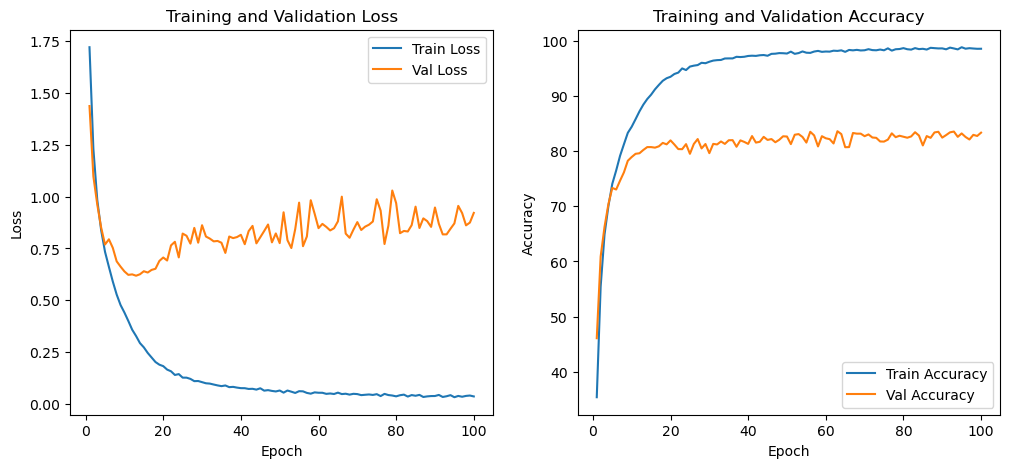

In [6]:
# 모델 저장
torch.save(model.state_dict(), 'vit_cifar10_11th_val_b64_p4.pth')

# 학습 곡선 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [7]:
model.eval()
running_test_loss = 0.0
running_test_correct = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        running_test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_test_correct += (preds == labels).sum().item()
        total_test += labels.size(0)

test_loss = running_test_loss / total_test
test_accuracy = running_test_correct / total_test

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0132, Test Accuracy: 0.8427
